# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *
from CubicGalileonEmu.mcmc import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt


if_train_all = False ## Re-train all the models. Time-consuming. 
if_mcmc_all = False  ## Full MCMC run. Time-consuming. 
if_savefig = False

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

### A few plotting routines

#### Experimental design

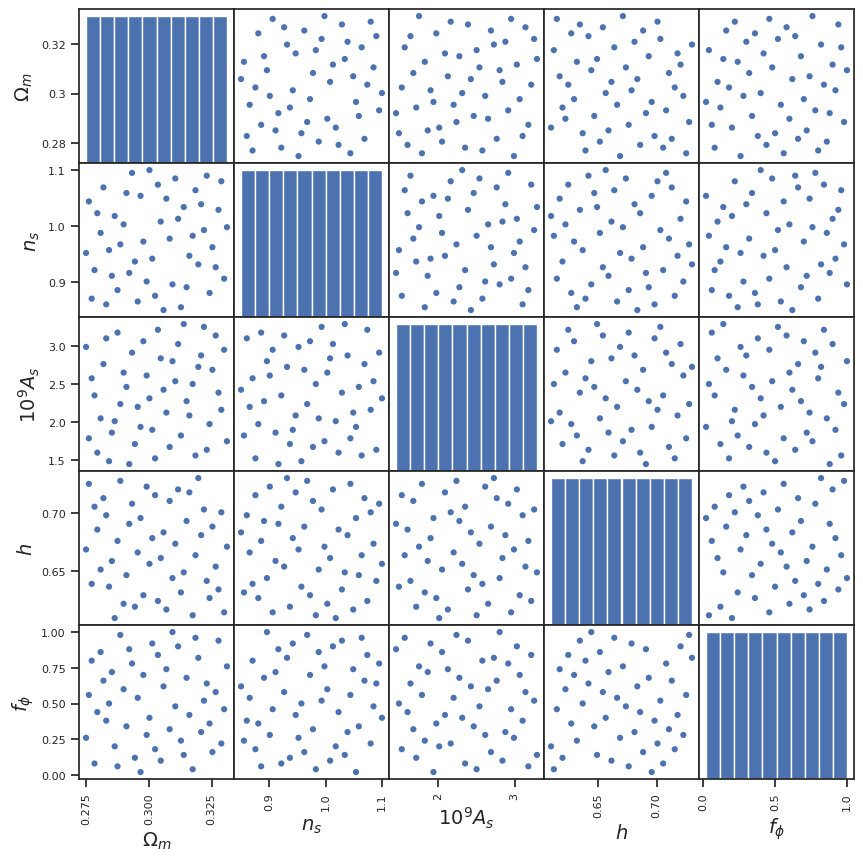

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);



#### Boost metrics colored by cosmology parameters

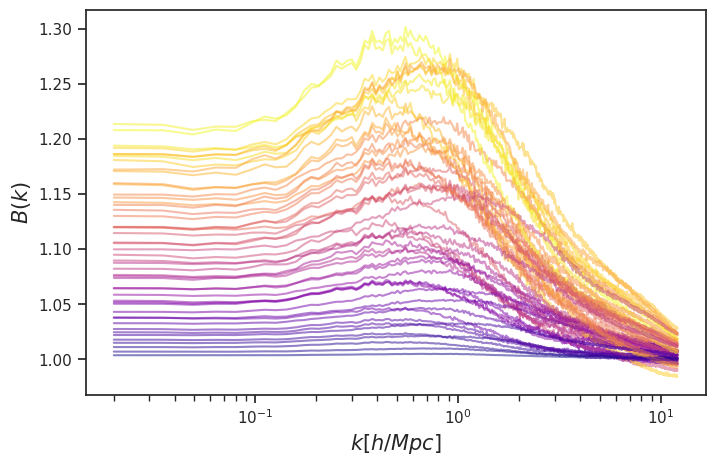

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

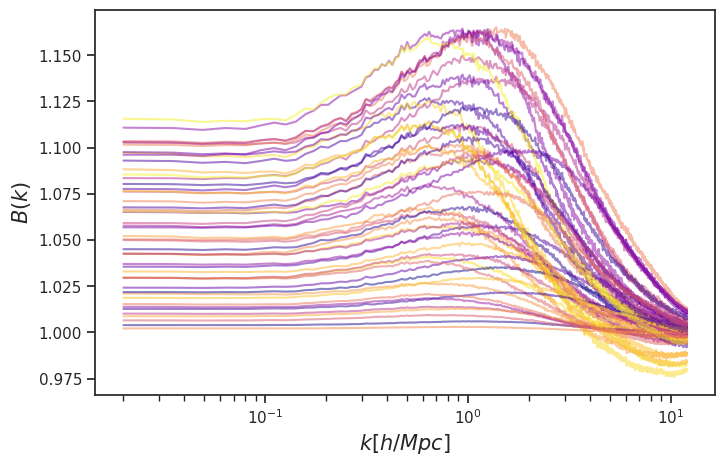

In [ ]:
#| hide 

color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

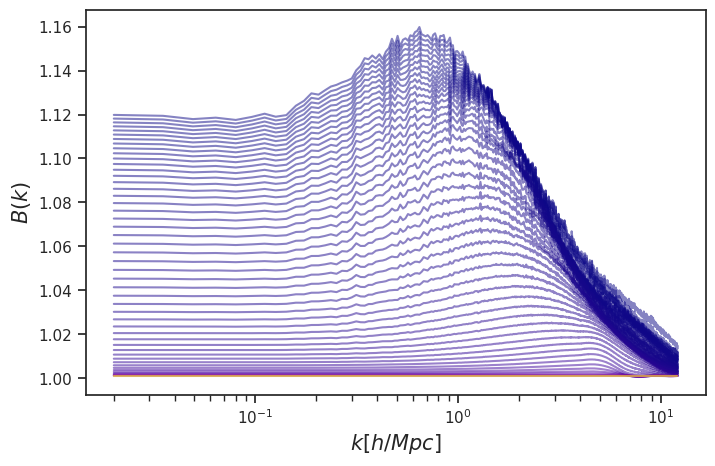

In [ ]:
#| hide 

z_index = 0

f = plot_lines_with_param_color(z_all, 
                            k_all, 
                            Bk_all[16, :, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            'redshift');

### Training involves: PCA, GP fitting.  

In [ ]:
## Data prep
z_index = 1
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all

# Train-test split
test_indices = [0, 14, 35]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(49) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = Bk_all[:, z_index, :][train_indices]
print('Redshift: ' + str(z_all[z_index]))

Redshift: 0.02


This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.3087862  0.24363744]
 [0.07108569 0.15199766]
 [0.14393258 0.74658792]
 [0.07662151 0.55919102]
 [0.13436938 0.45045721]
 [0.92719988 0.72508351]]
lamUz
[[1.04043937 1.31949468]]
lamWs
[[ 387.43516494 2271.25243549]]
lamWOs
[[14.25502712]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.16it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

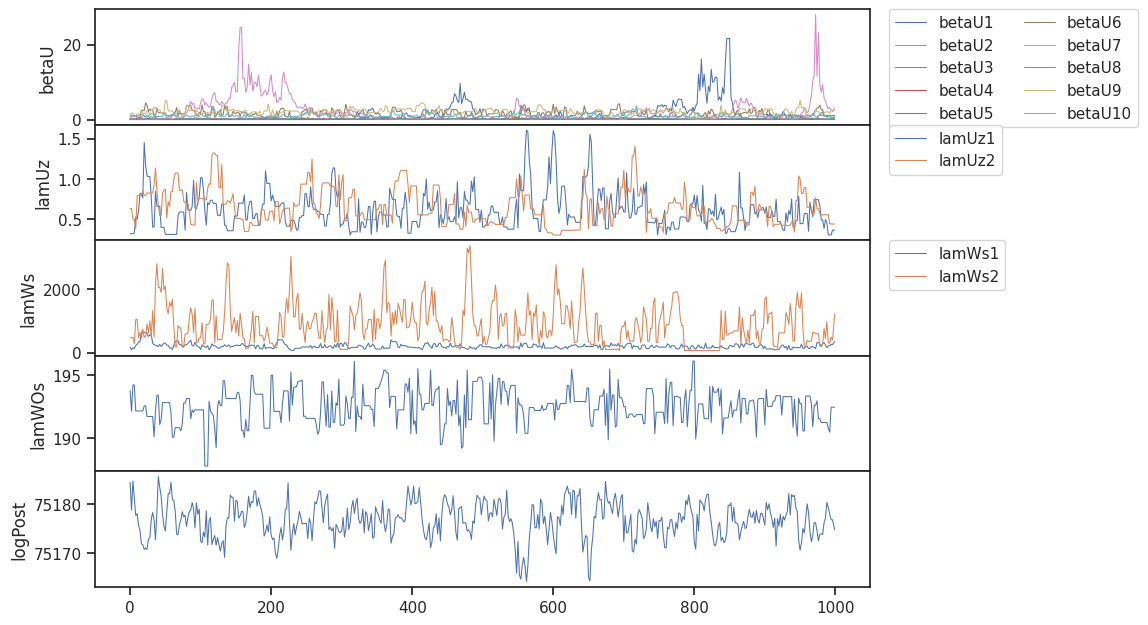

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

### Single-redshift emulation for new cosmological parameters

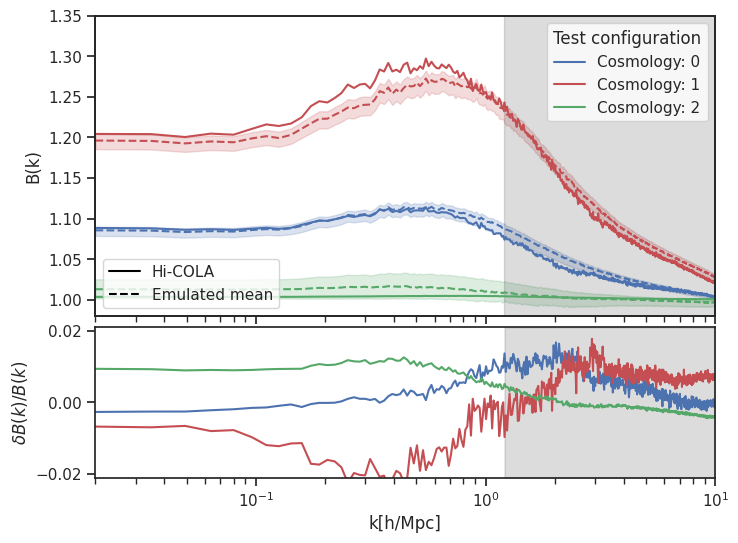

In [ ]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
# pred_quant == Emulated (0.05, 0.95) quantile
validation_plot(k_all, target_vals, pred_mean, pred_quant, xy_lims=[2e-2, 1e1, 0.98, 1.35]);

### Sensitivity analysis from the emulator 

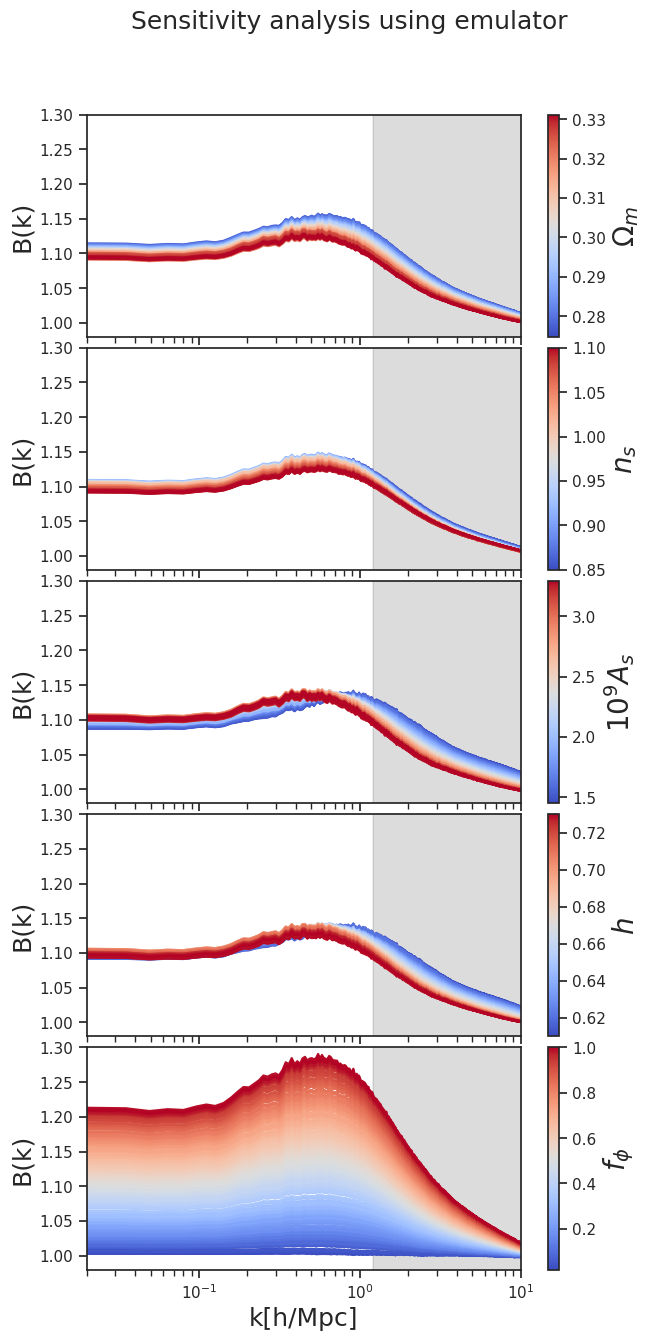

In [ ]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation

#### Train all the models

In [ ]:
if if_train_all:
    
    do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', 
                        p_train_all = p_all[train_indices],
                        y_vals_all = Bk_all[train_indices],
                        y_ind_all = k_all,
                        z_index_range=range(49))

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.01it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.16056295 0.40622642]
 [0.07184034 0.25027451]
 [0.23390387 0.7608165 ]
 [0.10583697 0.73540758]
 [0.11192581 0.67444935]
 [1.03519009 1.22541219]]
lamUz
[[1.05308083 1.54142217]]
lamWs
[[ 790.02622516 4047.95658548]]
lamWOs
[[12.92921327]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.09it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index0.pkl
Training complete for snapshot 0
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.12it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.17629118 0.61206392]
 [0.05969545 0.1691965 ]
 [0.12034785 0.76197456]
 [0.07951246 0.64565052]
 [0.13794586 0.44283993]
 [1.16823136 0.704161  ]]
lamUz
[[1.09716    1.22744522]]
lamWs
[[ 625.57118605 1758.80518777]]
lamWOs
[[12.80696265]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.17it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl
Training complete for snapshot 1
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.05it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.82507497 0.62448203]
 [0.06839836 0.15424664]
 [0.10641838 0.73720318]
 [0.06903922 0.67758336]
 [0.13323078 0.72318234]
 [1.05816319 0.81554574]]
lamUz
[[1.26420239 1.04621204]]
lamWs
[[ 407.60737393 3164.68553511]]
lamWOs
[[13.03957515]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.83it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index2.pkl
Training complete for snapshot 2
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.03it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.05401582 0.43695218]
 [0.09109823 0.25957102]
 [0.08955443 0.83702615]
 [0.08896421 0.78013973]
 [0.11614468 0.89534897]
 [0.62675447 0.81937547]]
lamUz
[[1.02837253 1.79708246]]
lamWs
[[ 447.02366966 2772.25689704]]
lamWOs
[[14.6800061]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.75it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index3.pkl
Training complete for snapshot 3
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.0791198  0.24677108]
 [0.10733067 0.32968863]
 [0.06775495 0.95086778]
 [0.09685911 0.73118094]
 [0.10207069 1.0257335 ]
 [0.57185173 0.93605519]]
lamUz
[[0.85598921 1.17277781]]
lamWs
[[ 335.44645418 2834.29020018]]
lamWOs
[[11.51425184]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.54it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index4.pkl
Training complete for snapshot 4
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.03it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.44980459 1.04308643]
 [0.13052054 0.48769194]
 [0.09432917 0.85719164]
 [0.13088204 1.01998941]
 [0.11590396 0.70805272]
 [0.64675905 0.99981812]]
lamUz
[[1.33862503 1.74273797]]
lamWs
[[ 359.46677985 1757.0266274 ]]
lamWOs
[[13.7580035]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.25it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index5.pkl
Training complete for snapshot 5
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.22it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.27641    0.32513858]
 [0.15140431 0.19959421]
 [0.11993487 0.36055509]
 [0.1195117  0.6553569 ]
 [0.11540639 0.4706263 ]
 [0.66428733 1.00208163]]
lamUz
[[1.31069428 1.13322446]]
lamWs
[[333.85130533 144.64728589]]
lamWOs
[[12.05207076]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index6.pkl
Training complete for snapshot 6
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.26it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.22638649 0.66348605]
 [0.11481039 0.22712885]
 [0.0731273  0.15764445]
 [0.1259787  0.41528222]
 [0.092791   0.32856721]
 [0.90603235 0.70140865]]
lamUz
[[1.13823766 0.97507845]]
lamWs
[[482.70026412 256.4218231 ]]
lamWOs
[[14.70576684]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.03it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index7.pkl
Training complete for snapshot 7
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.43311301 0.41465497]
 [0.11792445 0.22422622]
 [0.05911294 0.11099309]
 [0.10300938 0.37743739]
 [0.09024437 0.28872624]
 [0.79119649 0.90796446]]
lamUz
[[0.85943008 1.15605879]]
lamWs
[[494.62777782 352.71120663]]
lamWOs
[[15.05496002]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index8.pkl
Training complete for snapshot 8
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.24it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.13450565 0.19013031]
 [0.11139757 0.22495921]
 [0.04623665 0.09024116]
 [0.11574777 0.35461138]
 [0.08492302 0.22815777]
 [0.81365569 0.61275159]]
lamUz
[[1.11250873 0.98812361]]
lamWs
[[822.36824591 619.71711325]]
lamWOs
[[20.77163744]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.47it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index9.pkl
Training complete for snapshot 9
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.26it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.23661072 0.12775874]
 [0.0913779  0.16090914]
 [0.03697274 0.1033068 ]
 [0.1267362  0.359088  ]
 [0.0905021  0.23703629]
 [0.68105667 0.48426698]]
lamUz
[[0.7125765  0.73894466]]
lamWs
[[1078.71737145  484.88422972]]
lamWOs
[[15.49642527]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index10.pkl
Training complete for snapshot 10
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.19it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.29724566 0.36958966]
 [0.12576739 0.22398998]
 [0.04021671 0.22938917]
 [0.11862595 0.40130467]
 [0.10550837 0.29275418]
 [0.73730323 0.56458786]]
lamUz
[[0.66477636 1.14501828]]
lamWs
[[735.09468707 592.77632608]]
lamWOs
[[16.95371963]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.90it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index11.pkl
Training complete for snapshot 11
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.14389848 0.55236004]
 [0.15471206 0.47789963]
 [0.05286841 0.18553026]
 [0.15896319 0.43172297]
 [0.11035659 0.30530961]
 [0.59406508 0.61531485]]
lamUz
[[1.02060115 1.29248081]]
lamWs
[[527.35845479 892.52324883]]
lamWOs
[[16.00559189]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.62it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index12.pkl
Training complete for snapshot 12
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.10it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.21636236 0.36275872]
 [0.12837033 0.31995589]
 [0.04671136 0.09775634]
 [0.16779186 0.32227389]
 [0.11244803 0.29766656]
 [0.51665286 0.82202064]]
lamUz
[[0.88760003 0.85582605]]
lamWs
[[ 521.29016755 1022.65709554]]
lamWOs
[[11.81256323]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.96it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index13.pkl
Training complete for snapshot 13
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.14it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.42333968 0.90842225]
 [0.13861919 0.1415776 ]
 [0.03761286 0.09790857]
 [0.1395361  0.26491757]
 [0.14256026 0.22638859]
 [0.86370774 0.46371166]]
lamUz
[[1.08741942 0.79061264]]
lamWs
[[ 927.31479668 1264.26815288]]
lamWOs
[[15.60493884]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index14.pkl
Training complete for snapshot 14
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.22it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.79223204 0.84694843]
 [0.06202922 0.12533136]
 [0.03974149 0.10736807]
 [0.14079436 0.33619132]
 [0.07802096 0.197966  ]
 [1.05820326 0.345989  ]]
lamUz
[[0.58909098 0.64489902]]
lamWs
[[1412.79058238 1358.36800375]]
lamWOs
[[17.30576516]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.29it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index15.pkl
Training complete for snapshot 15
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.14it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.31648669 1.02524656]
 [0.08400066 0.14411171]
 [0.05072475 0.28893455]
 [0.12461488 0.34587856]
 [0.07102521 0.34885349]
 [1.21955738 0.42307016]]
lamUz
[[0.77332844 0.97317984]]
lamWs
[[2108.1046086  2236.19373031]]
lamWOs
[[14.73185867]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.33it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index16.pkl
Training complete for snapshot 16
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.15it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.20787669 0.3101342 ]
 [0.11722969 0.14284704]
 [0.07050203 0.27991527]
 [0.18279203 0.37358091]
 [0.11285637 0.32006376]
 [0.77324307 0.37536315]]
lamUz
[[0.79874124 0.76009857]]
lamWs
[[2508.99238601 2292.35100941]]
lamWOs
[[19.3888783]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.32it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index17.pkl
Training complete for snapshot 17
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.14it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.80896509 0.48530265]
 [0.10113116 0.10384529]
 [0.0591731  0.15116072]
 [0.21706256 0.33501948]
 [0.22214685 0.22124325]
 [0.54973377 0.45622676]]
lamUz
[[0.68985718 0.60706222]]
lamWs
[[3186.30872541  912.87503626]]
lamWOs
[[17.5818228]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.98it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index18.pkl
Training complete for snapshot 18
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.20it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.41569344 0.68320409]
 [0.08345983 0.10126701]
 [0.03935266 0.10461383]
 [0.20078526 0.37951413]
 [0.13864127 0.2571711 ]
 [0.65983496 0.52284291]]
lamUz
[[0.55937513 0.57537722]]
lamWs
[[3731.64279481 1061.90198721]]
lamWOs
[[16.04297863]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.32it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index19.pkl
Training complete for snapshot 19
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.14it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.53483787 0.42690708]
 [0.10401017 0.24209133]
 [0.06264092 0.16091428]
 [0.2277915  0.33145118]
 [0.13800401 0.22085351]
 [0.68518962 0.42748107]]
lamUz
[[0.81016688 0.53905629]]
lamWs
[[3304.38294817 2466.24180659]]
lamWOs
[[15.23182433]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.92it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index20.pkl
Training complete for snapshot 20
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.23it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.08347887 0.27803482]
 [0.09432791 0.17151675]
 [0.05395916 0.15280763]
 [0.14883756 0.34980888]
 [0.09517825 0.2666594 ]
 [0.51470587 0.42185567]]
lamUz
[[0.43518797 0.73418215]]
lamWs
[[3263.02567564 2269.4391726 ]]
lamWOs
[[16.64056288]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.61it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index21.pkl
Training complete for snapshot 21
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.11it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.04693757 0.41487854]
 [0.06951138 0.11466955]
 [0.06205395 0.17211284]
 [0.17583221 0.29595086]
 [0.11481362 0.24446556]
 [0.45423049 0.35985802]]
lamUz
[[0.59310881 0.86238241]]
lamWs
[[3103.50095893 2495.44549213]]
lamWOs
[[17.65127193]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.20it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index22.pkl
Training complete for snapshot 22
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.18it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.24314886 0.25919626]
 [0.07517463 0.19566967]
 [0.04620216 0.1506256 ]
 [0.12404471 0.37388743]
 [0.10462367 0.28229933]
 [0.5416576  0.32945793]]
lamUz
[[0.3891043  0.72472926]]
lamWs
[[2705.98887038 2089.46164947]]
lamWOs
[[17.48456625]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.14it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index23.pkl
Training complete for snapshot 23
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.10it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.62214556 0.92891227]
 [0.10413171 0.18777773]
 [0.06973256 0.11202929]
 [0.11327626 0.37185028]
 [0.1091165  0.2083019 ]
 [0.49188925 0.32702721]]
lamUz
[[0.43199031 0.5599963 ]]
lamWs
[[3500.09060467 3758.00464774]]
lamWOs
[[20.44721509]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.82it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index24.pkl
Training complete for snapshot 24
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.11864217 0.88388712]
 [0.07452828 0.1015381 ]
 [0.04618476 0.12651757]
 [0.15125807 0.42107484]
 [0.09683756 0.23456586]
 [0.52872367 0.48366378]]
lamUz
[[0.48099848 0.53989966]]
lamWs
[[3079.26461011 3568.09102961]]
lamWOs
[[21.99409681]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.81it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index25.pkl
Training complete for snapshot 25
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.41138251 0.37293307]
 [0.06837404 0.09185826]
 [0.05180879 0.11768599]
 [0.13138295 0.32952209]
 [0.10648414 0.20610552]
 [0.5350788  0.44025721]]
lamUz
[[0.56659446 0.51529886]]
lamWs
[[4839.83582605 3395.00300536]]
lamWOs
[[23.2286512]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.04it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index26.pkl
Training complete for snapshot 26
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.14it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.12294372 0.22416549]
 [0.10644657 0.15282922]
 [0.04521949 0.13596649]
 [0.13451068 0.28070759]
 [0.10409429 0.19585182]
 [0.49747219 0.39601994]]
lamUz
[[0.5158713  0.63402618]]
lamWs
[[3526.4087351  3808.37323593]]
lamWOs
[[26.01967593]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.16it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index27.pkl
Training complete for snapshot 27
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.20850819 3.69277296]
 [0.09767955 0.12984985]
 [0.0518485  0.13563435]
 [0.09863808 0.32812682]
 [0.09806253 0.21402681]
 [0.50285995 0.32580619]]
lamUz
[[0.41152175 0.60366315]]
lamWs
[[3036.93569821 4647.87825221]]
lamWOs
[[23.62486527]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.87it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index28.pkl
Training complete for snapshot 28
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.06it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.62532869 1.51747241]
 [0.12656238 0.15062628]
 [0.06142426 0.11857325]
 [0.12350924 0.36216538]
 [0.08104253 0.20267462]
 [0.58852394 0.3316282 ]]
lamUz
[[0.7982207  0.51685891]]
lamWs
[[3293.82273915 3412.78758284]]
lamWOs
[[37.61540849]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.84it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index29.pkl
Training complete for snapshot 29
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.67271344 0.19982118]
 [0.10647699 0.11657608]
 [0.05126818 0.08485285]
 [0.15530331 0.37197316]
 [0.13295005 0.24098369]
 [0.5994101  0.35818928]]
lamUz
[[0.41993742 0.66647712]]
lamWs
[[3246.43128961 4509.40110009]]
lamWOs
[[32.58176185]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.13it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index30.pkl
Training complete for snapshot 30
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.15it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.51041983 0.37068809]
 [0.09940345 0.14710674]
 [0.05826456 0.09768152]
 [0.12678415 0.28736694]
 [0.09610749 0.29274067]
 [0.54549413 0.34289634]]
lamUz
[[0.49409516 0.70833301]]
lamWs
[[4038.79344099 3679.67051004]]
lamWOs
[[30.01813888]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index31.pkl
Training complete for snapshot 31
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.12it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.77511916 0.29773807]
 [0.07524386 0.09685425]
 [0.04104724 0.07806892]
 [0.13197976 0.30722207]
 [0.11337358 0.34428761]
 [0.46139837 0.35882369]]
lamUz
[[0.39825628 0.56063064]]
lamWs
[[5141.20066993 5092.16747492]]
lamWOs
[[27.7902077]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.29it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index32.pkl
Training complete for snapshot 32
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.24204837 1.16145246]
 [0.07376406 0.0731135 ]
 [0.05177896 0.10608123]
 [0.15335957 0.2971668 ]
 [0.11584922 0.34974211]
 [0.45565832 0.37136526]]
lamUz
[[0.57741978 0.5401117 ]]
lamWs
[[4190.88700309 4646.14033874]]
lamWOs
[[27.82707065]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.35it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index33.pkl
Training complete for snapshot 33
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.45494066 0.10470256]
 [0.07660087 0.11012203]
 [0.04920783 0.08475661]
 [0.111237   0.31244009]
 [0.11322037 0.43258731]
 [0.53153502 0.34973223]]
lamUz
[[0.58703905 0.64962113]]
lamWs
[[3937.76190501 4942.60507902]]
lamWOs
[[24.04634443]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.27it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index34.pkl
Training complete for snapshot 34
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.09it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.2536514  1.15556766]
 [0.07035192 0.11981075]
 [0.05788351 0.11864259]
 [0.15396889 0.38288862]
 [0.09300924 0.50540882]
 [0.48127751 0.38690127]]
lamUz
[[0.50223898 0.87345592]]
lamWs
[[3898.97712576 4592.22194389]]
lamWOs
[[14.42131712]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.41it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index35.pkl
Training complete for snapshot 35
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.06it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.55155756 0.63931508]
 [0.0912577  0.12175407]
 [0.05964301 0.13089273]
 [0.18574814 0.41462578]
 [0.13863881 0.54377977]
 [0.4863038  0.442475  ]]
lamUz
[[1.12654588 1.10095609]]
lamWs
[[4585.19674027 4654.85428833]]
lamWOs
[[10.41743094]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.07it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index36.pkl
Training complete for snapshot 36
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.13it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.8229216  0.12814642]
 [0.06084376 0.08785754]
 [0.05345716 0.18071962]
 [0.170563   0.36560615]
 [0.14368748 0.40516592]
 [0.38851947 0.45406646]]
lamUz
[[0.94916333 0.98030245]]
lamWs
[[5620.25969358 3946.9708911 ]]
lamWOs
[[6.14203979]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.58it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index37.pkl
Training complete for snapshot 37
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.41it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.38613381]
 [0.05617037]
 [0.05072478]
 [0.21768938]
 [0.13128448]
 [0.38272153]]
lamUz
[[0.78754409]]
lamWs
[[4783.97566681]]
lamWOs
[[0.0074157]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.29it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index38.pkl
Training complete for snapshot 38
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.24it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.85574574]
 [0.05125829]
 [0.06705593]
 [0.23483232]
 [0.12898263]
 [0.48728362]]
lamUz
[[0.91863804]]
lamWs
[[4614.03407633]]
lamWOs
[[0.00773644]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.89it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index39.pkl
Training complete for snapshot 39
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.31it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.12678642]
 [0.04388163]
 [0.05503754]
 [0.26822352]
 [0.10550959]
 [0.3936836 ]]
lamUz
[[0.78692654]]
lamWs
[[5240.10010216]]
lamWOs
[[0.00929871]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.34it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index40.pkl
Training complete for snapshot 40
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.43it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.71007542]
 [0.03247787]
 [0.05020515]
 [0.27185434]
 [0.12097446]
 [0.42905314]]
lamUz
[[0.94968599]]
lamWs
[[5927.0490482]]
lamWOs
[[0.02149028]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.56it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index41.pkl
Training complete for snapshot 41
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.45it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.74935833]
 [0.0308878 ]
 [0.02040995]
 [0.28240147]
 [0.12279639]
 [0.48587501]]
lamUz
[[0.98728696]]
lamWs
[[3882.39066585]]
lamWOs
[[0.03840343]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.88it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index42.pkl
Training complete for snapshot 42
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.44it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.50190091]
 [0.03589242]
 [0.01070709]
 [0.21228838]
 [0.0718497 ]
 [0.67342919]]
lamUz
[[1.66415254]]
lamWs
[[2649.42603915]]
lamWOs
[[3.84130647]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.94it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index43.pkl
Training complete for snapshot 43
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.66it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.87510036]
 [0.02909013]
 [0.00930927]
 [0.07874915]
 [0.00552069]
 [0.77644294]]
lamUz
[[1.23644379]]
lamWs
[[1493.95074359]]
lamWOs
[[6.33915188]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.39it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index44.pkl
Training complete for snapshot 44
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.68it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.40786275]
 [0.03934978]
 [0.01123869]
 [0.02442116]
 [0.01241131]
 [0.7241828 ]]
lamUz
[[1.68600136]]
lamWs
[[1114.67115714]]
lamWOs
[[6.31890425]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.52it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index45.pkl
Training complete for snapshot 45
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.59it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.26245142]
 [0.05448627]
 [0.00816974]
 [0.01278181]
 [0.04390004]
 [0.98657148]]
lamUz
[[1.90693615]]
lamWs
[[797.84797106]]
lamWOs
[[9.48543967]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.53it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index46.pkl
Training complete for snapshot 46
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.71it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.2587073 ]
 [0.04018788]
 [0.00647025]
 [0.00637383]
 [0.06982616]
 [0.93111782]]
lamUz
[[1.72364541]]
lamWs
[[689.91671225]]
lamWOs
[[21.58384731]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.76it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index47.pkl
Training complete for snapshot 47
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.51it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.47677757]
 [0.04428871]
 [0.00916853]
 [0.00589791]
 [0.07729976]
 [1.37665668]]
lamUz
[[1.40334739]]
lamWs
[[761.54833599]]
lamWOs
[[113.54211913]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.70it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index48.pkl
Training complete for snapshot 48
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


#### Load all trained models 

In [ ]:
sepia_model_list = load_model_multiple(model_dir='../CubicGalileonEmu/model/', 
                                        p_train_all=p_all[train_indices],
                                        y_vals_all=Bk_all[train_indices],
                                        y_ind_all=k_all,
                                        z_index_range=range(49), 
                                        sepia_model_i=sepia_model)

Number of models loaded: 49
[[0.31051392 1.085      2.541      0.67373333 0.480012   0.05      ]]
redshift:  0.085
Burn-in phase
time (minutes): 1.7013330459594727
Sampling phase
time (minutes): 13.852111287911733
mcmc results: 0.3078656579147825 1.0579150686824421 2.525483445133132 0.6811089315373619 0.46340122308194626
[177.33067341 220.85359199 191.61895356 194.87426374 171.49393008]


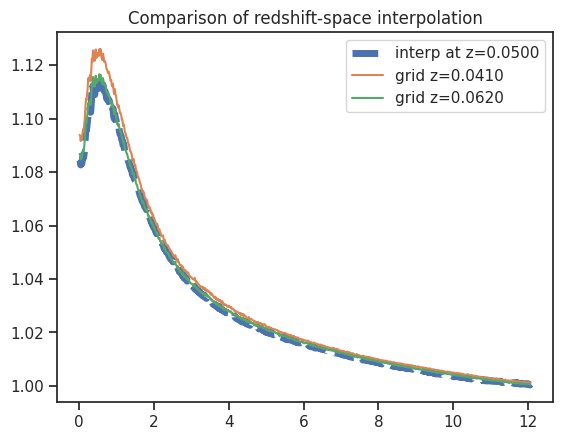

In [ ]:
#| hide

#### Emulator uncertainty across parameter range


input_params0 = input_params[0]
z_inputs = 0.05
input_params_and_redshift = np.append(input_params0, z_inputs)
print(input_params_and_redshift[np.newaxis, :])


emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
## There is an unknown issue with z_index=5 model, (sepia_model_list[6])
emulate(sepia_model_list[6], input_params_and_redshift[:-1])[0]


plt.figure(433)
plt.plot(k_all, emulated_with_redshift[:, 0], label='interp at z=%.4f'%input_params_and_redshift[-1], lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[0], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[2])
plt.plot(k_all, emulate(sepia_model_list[1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[3])
plt.legend()
plt.title('Comparison of redshift-space interpolation')
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

plt.show()

#### Emulator confidence across parameter range

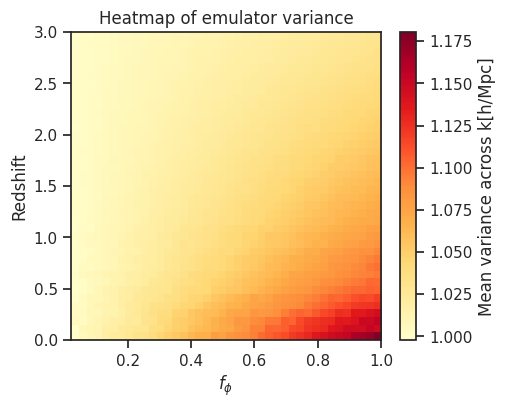

In [ ]:
# Parameter settings
steps = 40  # Number of steps in the grid for each parameter
param_name_extended = np.append(PARAM_NAME, 'Redshift')

param_min = np.append(p_all.min(axis=0), 0)
param_max = np.append(p_all.max(axis=0), 3)
param_mean = np.append(p_all.mean(axis=0), 1.0)

# Compute outputs and errors for a range of parameter values
def compute_errors(param_grid):
    errors = np.array([np.mean(emu_redshift(params[np.newaxis, :], sepia_model_list, z_all)[1][:, 0, :]**2)
                       for params in param_grid])
    return errors.reshape(steps, steps)

# Example usage:
param_indices = [4, 5]  # Indices of parameters to vary
fixed_indices = [i for i in range(len(param_name_extended)) if i not in param_indices]
fixed_params = {param_name_extended[i]: param_mean[i] for i in fixed_indices}

param_grid = generate_param_grid_with_fixed(param_name_extended, param_indices, fixed_params, param_min, param_max, steps)
errors = compute_errors(param_grid)
f = plot_error_heatmap(errors, [param_name_extended[i] for i in param_indices], [(param_min[param_indices[0]], param_max[param_indices[0]]), (param_min[param_indices[1]], param_max[param_indices[1]])])

if if_savefig: 
    f.savefig('../../../Plots/heatmap_params_4_5.png', bbox_inches='tight')

### Parameter inference via MCMC using the emulator

In [ ]:
#| hide 

ndim = 5
nwalkers = 50  # 500
nrun_burn = 100  # 300
nrun = 1000  # 700

#### Creating mock observational data

In [ ]:

target_indx = 0 #0 ,14, 35
z_index = 4
L = 32
fake_obs_data_index_every = 2

redshift = z_all[z_index]
x = k_all[::fake_obs_data_index_every]
y = Bk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]
y = y + 1e-3*np.random.normal(0.0, 1.0, size=y.shape)
yerr = np.sqrt( Bk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]*(L**3))/(L**3)

x_grid = k_all
params_calib = p_all[target_indx][:, np.newaxis].T
print('redshift: ', redshift)

<matplotlib.legend.Legend>

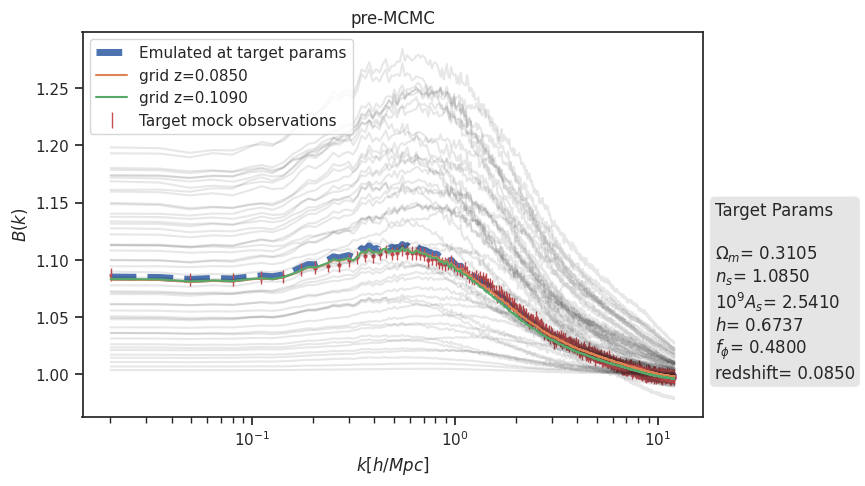

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(params_calib, redshift)
bk_target, err_target = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_target[:, 0], label='Emulated at target params', lw=5, ls='--')
a.errorbar(x, y, yerr, label='Target mock observations', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r")


a.plot(k_all, Bk_all[:, z_index, :].T, 'k', alpha=0.1)


plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index])
plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index + 1])

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.4f'%input_params_and_redshift[0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.4f'%input_params_and_redshift[1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.4f'%input_params_and_redshift[2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.4f'%input_params_and_redshift[3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.4f'%input_params_and_redshift[4] + '\n'
string_print6 = 'redshift' + '= %.4f'%input_params_and_redshift[5] 


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.1, string_print, transform=a.transAxes, fontsize=12, bbox=props)


a.set_xscale('log')
plt.title('pre-MCMC')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$B(k)$')
plt.legend()

In [ ]:
#| hide 

allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] 
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[2]]
param5 = [PARAM_NAME[4], params_calib[0][4], allMin[4], allMax[4]]

params_list = [param1, param2, param3, param4, param5]

In [ ]:
pos0 = chain_init(params_list, ndim, nwalkers)
sampler = define_sampler(redshift, ndim, nwalkers, params_list, x_grid, sepia_model_list, z_all, x, y, yerr)

##### MCMC run - first burn, then full. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:38<00:00,  1.22it/s]


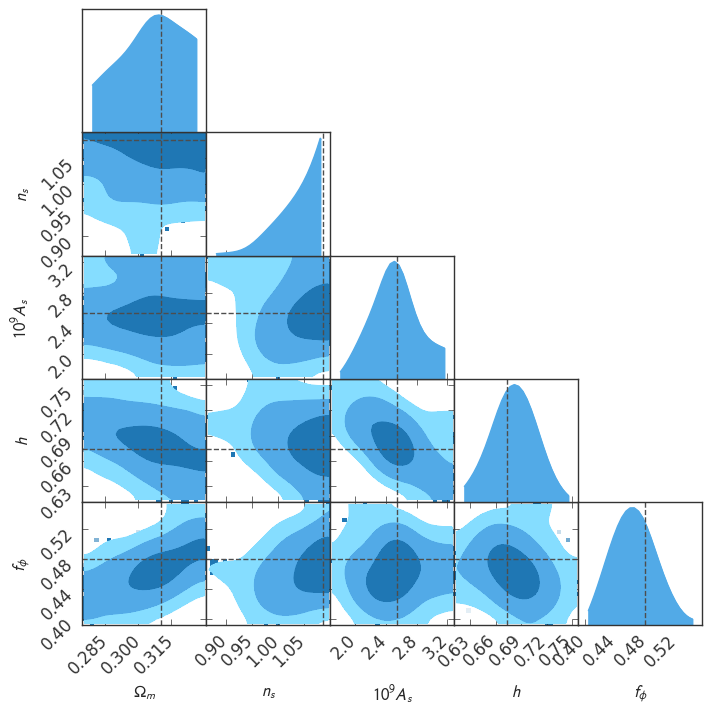

In [ ]:

pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos0, nrun_burn, ndim, if_burn=True)

if if_mcmc_all: # Full MCMC-run, will be slow
    pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos, nrun, ndim, if_burn=False)

p_mcmc = mcmc_results(samples)

fig = plot_mcmc(samples, params_list, if_truth_know=True)
if if_savefig: 
    plt.savefig('../../../Plots/mcmc_plot.png', bbox_inches='tight')

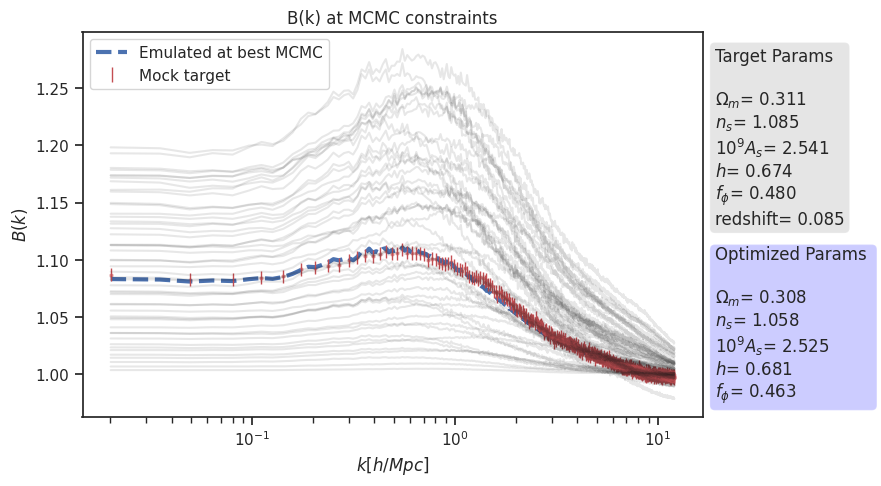

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(p_mcmc, redshift)
bk_mcmc, err_mcmc = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_mcmc[:, 0], label='Emulated at best MCMC', lw=3, ls='--')
a.errorbar(x, y, yerr, label='Mock target', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r", alpha=0.5)

a.plot(k_all, Bk_all[:, z_index, :].T, 'k', alpha=0.1)


# plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='Z1')
# plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='Z2')

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.3f'%params_calib[0][0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.3f'%params_calib[0][1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.3f'%params_calib[0][2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.3f'%params_calib[0][3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.3f'%params_calib[0][4] + '\n'
string_print6 = 'redshift' + '= %.3f'%redshift


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.5, string_print, transform=a.transAxes, fontsize=12, bbox=props)

string_print0_mcmc = 'Optimized Params \n\n' 
string_print1_mcmc = PARAM_NAME[0] + '= %.3f'%p_mcmc[0] + '\n'
string_print2_mcmc = PARAM_NAME[1] + '= %.3f'%p_mcmc[1] + '\n'
string_print3_mcmc = PARAM_NAME[2] + '= %.3f'%p_mcmc[2] + '\n'
string_print4_mcmc = PARAM_NAME[3] + '= %.3f'%p_mcmc[3] + '\n'
string_print5_mcmc = PARAM_NAME[4] + '= %.3f'%p_mcmc[4] 

string_print_mcmc = string_print0_mcmc + string_print1_mcmc + string_print2_mcmc + string_print3_mcmc + string_print4_mcmc + string_print5_mcmc

props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
plt.text(1.02, 0.05, string_print_mcmc, transform=a.transAxes, fontsize=12, bbox=props)



a.set_xscale('log')
plt.title('B(k) at MCMC constraints')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$B(k)$')
plt.legend()

if if_savefig: 
    plt.savefig('../../../Plots/mcmc_results_Bk.png', bbox_inches='tight')


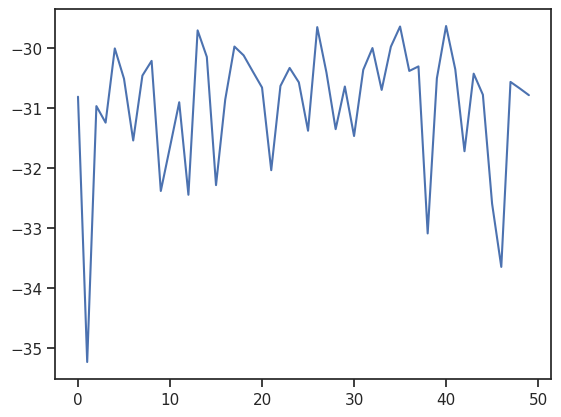

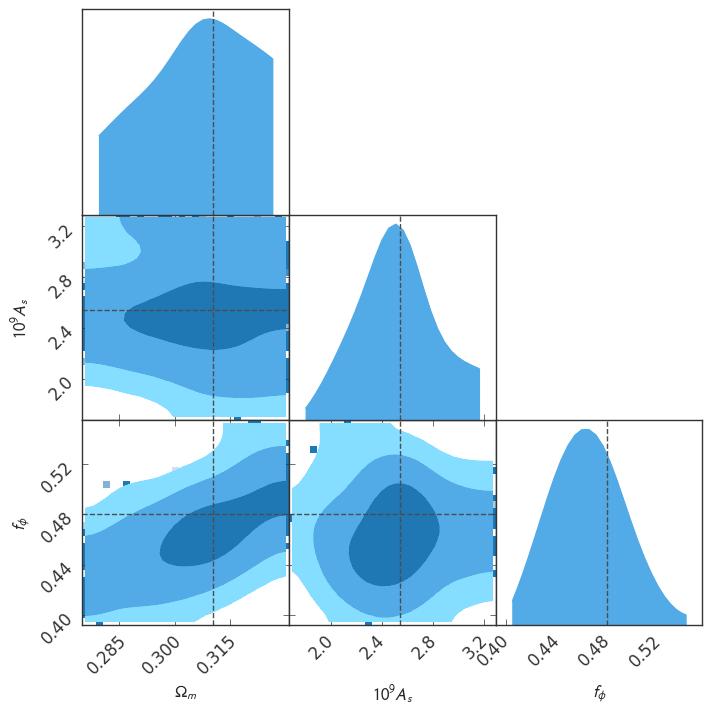

In [ ]:
#| hide


if if_mcmc_all:
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)

    plt.figure(43)
    plt.plot(prob)
    if if_savefig: 
        plt.savefig('../../../Plots/prob_plot.png', bbox_inches='tight')

    selected_indices_for_plot = [0, 2, 4]
    fig = plot_mcmc(samples[:, selected_indices_for_plot], [params_list[i] for i in selected_indices_for_plot], if_truth_know=True)

    if if_savefig: 
        plt.savefig('../../../Plots/mcmc_plot_reduced_params.png', bbox_inches='tight')

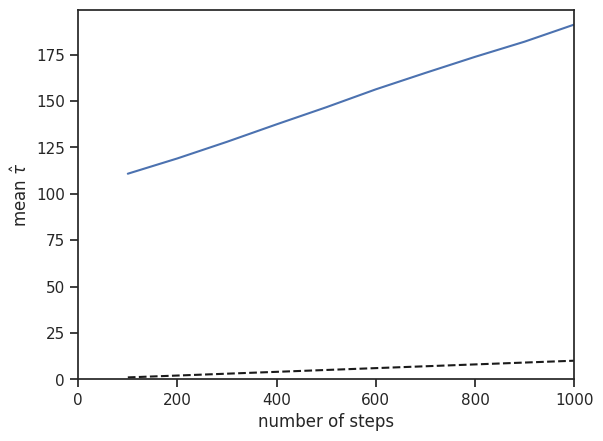

In [ ]:
#| hide

if if_mcmc_all:

    n = 100 * np.arange(1, index + 1)
    y = autocorr[:index]
    plt.plot(n, n / 100.0, "--k")
    plt.plot(n, y)
    plt.xlim(0, n.max())
    plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$");
    plt.show()

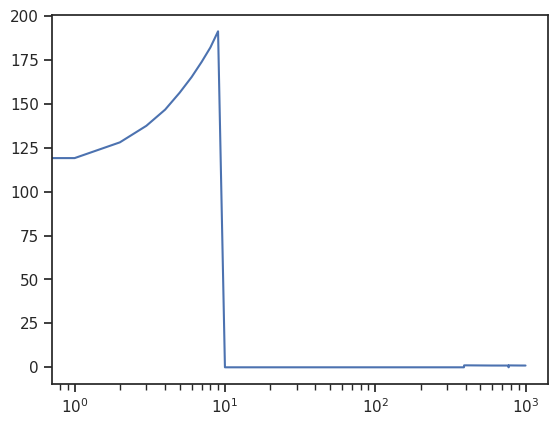

In [ ]:
#| hide

if if_mcmc_all:
    plt.plot(autocorr)
    plt.xscale('log')
    # plt.yscale('log')